In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")
import pandas as pd
import random as rand
import string
import math
chars = string.ascii_uppercase + string.digits
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
import seaborn as sns
import sklearn as skl
import skimage as ski
from sklearn.preprocessing import LabelEncoder
from scipy import spatial
from sklearn.utils import shuffle
from os import system
import skimage as ski
from skimage.color import rgb2gray
from scipy import misc
from skimage.exposure import adjust_gamma

# setting up number of microsats and number of alleles per microsat

In [2]:
NMICROSATS = 5
NALLELEPERMICROSAT = 3
topology = ski.img_as_float(rgb2gray(misc.imread("roads/noroad.png")))
topology.shape

(500, 1000)

# generate new individuals functions

In [3]:


population = pd.DataFrame(columns = ['Boldness', 'Sex', 'Age', 'Position'] + ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)])
population.index.name = 'name'

def generate_random_coyote(N):
    df = pd.DataFrame( columns = ['Boldness', 'Sex', 'Age'])
    df.index.name='name'
    for i in range(N):
        new_coyote = pd.DataFrame()
        new_coyote['name'] = ["Coyote"+"".join([rand.choice(chars) for k in range(6)])]
        new_coyote["Position"] = [np.array([rand.uniform(0,topology.shape[0]-1),rand.uniform(0,topology.shape[1]-1)])]
        new_coyote['Sex'] = np.random.choice(["male", "female"], 1)
        new_coyote['Age'] =  np.random.normal(3, 1., 1)
        for n in range(NMICROSATS):
            new_coyote["mSat"+ str(n+1).zfill(2)] = [tuple([rand.choice(string.ascii_uppercase[:NALLELEPERMICROSAT]), rand.choice(string.ascii_uppercase[:NALLELEPERMICROSAT])])]
        
        new_coyote['Boldness'] = [rand.random()]
        new_coyote = new_coyote.set_index(new_coyote.name)
        del new_coyote["name"]
        
        df =df.append(new_coyote)
    return df
        

    
def coyote_puppy(momma, poppa, N):
    global population
    df = pd.DataFrame( columns = ['Boldness', 'Sex', 'Age'])
    df.index.name='name'
    for i in range(N):
        puppy = pd.DataFrame()
        puppy['name'] = ["Coyote"+"".join([rand.choice(chars) for k in range(6)])]
        
        puppy['Age'] =[.5]
        puppy["Position"] = [np.array([momma.Position[0]+rand.uniform(-3,3), momma.Position[1]+rand.uniform(-3,3)])]
        puppy['Sex'] = np.random.choice(["male", "female"], 1)
        for n in range(NMICROSATS):
            alleles_from_parents = [np.random.choice(momma["mSat"+ str(n+1).zfill(2)], 1)[0], np.random.choice(poppa["mSat"+ str(n+1).zfill(2)], 1)[0]]
            if rand.random() < 10**(-3): #mutation rate
                print("new allele")
                which_allele_to_mutate = rand.randint(0,1) 
                alleles_from_parents[which_allele_to_mutate] += rand.choice(string.ascii_lowercase)
            puppy["mSat"+ str(n+1).zfill(2)] = [tuple(alleles_from_parents)]
        puppy['Boldness'] = [(momma.Boldness + poppa.Boldness)/2 +.005*rand.uniform(-1,1)]
        puppy = puppy.set_index(puppy.name)
        del puppy["name"]
        df =df.append(puppy)
    
    population = pd.concat([population,df])
    


# Generate initial population

In [4]:
NMICROSATS = 5
NALLELEPERMICROSAT = 3

population = pd.concat([population, generate_random_coyote(100)])

population.head()


,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote3IVGJJ,3.851402,0.278186,"[441.432365506, 988.0631775]",male,"(A, A)","(A, A)","(B, C)","(A, B)","(B, B)"
CoyoteB0NWCB,1.236379,0.140305,"[463.562336305, 554.667792633]",male,"(B, C)","(A, A)","(B, A)","(B, C)","(B, B)"
Coyote6UGJRX,1.375274,0.976533,"[495.716051192, 913.999708231]",female,"(C, A)","(B, A)","(B, B)","(A, A)","(B, C)"
CoyoteC6K7JT,3.407650,0.743523,"[115.473028741, 762.873763028]",male,"(C, C)","(C, B)","(A, B)","(C, B)","(C, A)"
CoyoteEEL4V8,2.834270,0.447710,"[324.619724137, 438.641902872]",male,"(C, A)","(A, B)","(B, A)","(B, A)","(C, A)"


In [5]:
population.iloc[2].Position[1]

913.99970823132924

In [6]:
coyote_puppy(population.iloc[2], population.iloc[1], 4)
population.tail()


,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
CoyoteIOWS3C,5.837277,0.736076,"[25.1302046284, 968.689626736]",female,"(C, C)","(B, C)","(C, B)","(A, B)","(B, A)"
CoyoteVDJYLK,0.500000,0.560594,"[495.049724444, 912.326495984]",male,"(A, C)","(B, A)","(B, B)","(A, B)","(C, B)"
CoyotePHJJYW,0.500000,0.561088,"[494.432517548, 916.73195841]",male,"(A, B)","(B, A)","(B, A)","(A, C)","(C, B)"
Coyote1L0G21,0.500000,0.562000,"[495.786475558, 912.622386957]",male,"(A, B)","(B, A)","(B, A)","(A, C)","(B, B)"
Coyote7JT140,0.500000,0.554493,"[497.557162396, 913.763122786]",male,"(A, C)","(A, A)","(B, B)","(A, B)","(C, B)"


# Functions to calculate Heterozigosity and FST

In [7]:
def Heterozigosity(loci, pop):
    result = 0
    for i in pop[loci].values:
        if i[0] != i[1]: result += 1
    return result/pop.shape[0]

def AllHeterozigosity(pop):
    return [Heterozigosity(i, pop) for i in ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]]

def FST():
    example = population.copy()
    example['side'] = example.Position.apply(lambda x: ["A" if x[1]>500 else "B"][0])
    example.head()
    sidea = example[example.side == 'A']
    sideb = example[example.side == 'B']
    if sidea.shape[0] == 0 or sideb.shape[0]==0: return np.array([0 for i in range(NMICROSATS)])
    HA = np.array(AllHeterozigosity(sidea))
    HB = np.array(AllHeterozigosity(sidea))
    Hpop = np.array(AllHeterozigosity(population))         
    return (Hpop - (HA+HB)/2)/ Hpop

        

# Plot individuals on grid

In [8]:
def plot_on_map():
    example = population.copy()
    example['posx'] = example.Position.apply(lambda x: x[1])
    example['posy'] = example.Position.apply(lambda x: x[0])
    ax =example[example.Sex == 'female'].plot.scatter('posx', 'posy', c = 'Age' , cmap = 'Reds',s = example.Boldness.apply(lambda x : math.log10(abs(x)*1000000)*30), colorbar = False)
    example[example.Sex == 'male'].plot.scatter('posx', 'posy', c = 'Age' , cmap = 'Blues',s = example.Boldness.apply(lambda x : math.log10(abs(x)*1000000)*30),colorbar = False,  ax =ax)
    plt.xlim([0,topology.shape[1]])
    plt.ylim([0,topology.shape[0]])

    

#plot_on_map()

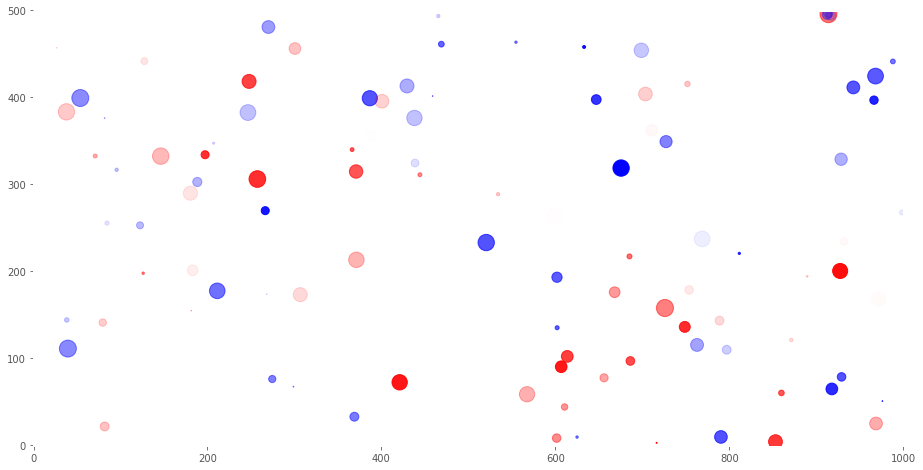

In [9]:
def plot_on_map2():
    plt.rcParams["figure.figsize"] = (16,8)
    fig, ax = plt.subplots(1, 1)
    plt.imshow(topology,  origin='lower', cmap= 'gray', vmin =0, vmax =1)
    #ax.grid(False)
    #ax.axis('off')
    for row in population.itertuples():
        y, x, r = row.Position[0], row.Position[1], row.Boldness
        if row.Sex == 'male': color = 'blue'
        else:                 color = 'red'
        c = plt.Circle((x, y) ,r*10, color=color, linewidth=1, alpha = 0.4*row.Age)
        ax.add_patch(c)
    #ax.text(x,y, str(number), color = 'white')

plot_on_map2()

# function for migration

In [10]:
def migration(position, dt, age, boldfac):
    global topology
    speed = [2,7,5,5,4,3,3,2,2,1,1,1,1,1,1,1][int(age)]
    angle = 2*math.pi*rand.random()
    distance = np.array([math.sin(angle), math.cos(angle)])*dt*speed*50
    pfy, pfx = position[0]+distance[0], position[1]+distance[1]
    
    
    if pfx > (topology.shape[1]-1): pfx = 2*(topology.shape[1]-1) - (distance[1] + position[1]) 
    if pfy > (topology.shape[0]-1): pfy = 2*(topology.shape[0]-1) - (distance[0] + position[0]) 
    if pfx < 0: pfx = abs(pfx)
    if pfy < 0: pfy = abs(pfy)
        
        
    if int(pfx) == int(position[1]) or int(pfy) == int(position[0]): surviveProb =1 
        #there is something weird here, There is a case that just enters this clause

    elif int(pfx) == int(position[1]):
        if int(pfy) == int(position[0]):  surviveProb = topology[int(pfy) ,int(pfx)]
        elif int(pfy) > int(position[0]): surviveProb = topology[int(position[0]):int(pfy), int(pfx)].mean()
        else:                             surviveProb = topology[int(pfy):int(position[0]), int(pfx)].mean()
            
    elif int(pfy) == int(position[0]):
        if int(pfx) > int(position[1]):   surviveProb = topology[int(pfy), int(pfx): int(position[1])].mean()
        else:                             surviveProb = topology[int(pfy), int(position[1]): int(pfx)].mean()
        
    elif int(pfx) > int(position[1]):
        if int(pfy) > int(position[0]): surviveProb = topology[int(position[0]):int(pfy), int(position[1]): int(pfx)].mean()
        else: surviveProb = topology[int(pfy):int(position[0]) , int(position[1]): int(pfx)].mean()

    else:
        if int(pfy) > int(position[0]): surviveProb = topology[int(position[0]): int(pfy), int(pfx) :int(position[1])].mean()
        else: surviveProb = topology[int(pfy):int(position[0]) ,int(pfx): int(position[1])].mean()
            
    
    if (1- surviveProb) > boldfac: return [position[0], position[1]]
    if rand.random()*.8 > surviveProb: return np.NAN
    
    return [pfy,pfx]

#testing
#population["Position"]= population.apply(lambda x: migration(x['Position'], 1, x['Age']), axis = 1)
#population = population.dropna()
#population.head()

    
    

# Function for Aging

In [11]:
def aging(age , dt):
    return age + dt

population['Age'] = population["Age"].apply(lambda x: aging(x, 1/24/365))
population.head()

,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote3IVGJJ,3.851516,0.278186,"[441.432365506, 988.0631775]",male,"(A, A)","(A, A)","(B, C)","(A, B)","(B, B)"
CoyoteB0NWCB,1.236493,0.140305,"[463.562336305, 554.667792633]",male,"(B, C)","(A, A)","(B, A)","(B, C)","(B, B)"
Coyote6UGJRX,1.375388,0.976533,"[495.716051192, 913.999708231]",female,"(C, A)","(B, A)","(B, B)","(A, A)","(B, C)"
CoyoteC6K7JT,3.407764,0.743523,"[115.473028741, 762.873763028]",male,"(C, C)","(C, B)","(A, B)","(C, B)","(C, A)"
CoyoteEEL4V8,2.834384,0.447710,"[324.619724137, 438.641902872]",male,"(C, A)","(A, B)","(B, A)","(B, A)","(C, A)"


# Function for Dieing

In [12]:
#calc probs of surviving for x years
print(.9987**365 * .9996**365 * .9996**365 * .9987**365 *.998**365 *.995**365)

#tested and working
def dieying(Age):
    prob_of_surviving_by_age_per_day = [.9987, .9996, .9996, .9987, .998, .995, .99, .985, .98, .977, .9, .8,.7,.5, 0]
    prob_seeing_another_day = prob_of_surviving_by_age_per_day[int(Age)]
    if rand.random()>prob_seeing_another_day: return True
    return False

#using dieing function

def killsome():
    global population
    population['willdie'] = population['Age'].apply(dieying)
    population = population[population["willdie"]== False]
    del population['willdie']

print(population.shape)
killsome()
print(population.shape)




0.022326420163582696
(104, 9)
(104, 9)


# Function for giving birth 


In [13]:
def nearest_male(female):
    males = population[population['Sex'] == 'male']
    distances_list = np.array(males["Position"].values.tolist())
    distance,indexx = spatial.KDTree(distances_list).query(np.array(female['Position']))
    return males.iloc[indexx]
    

def procreate(female):
    global population
    breeding_ages = [[1 + x-(1/365)/2, 1+x +(1/365)/2] for x in range(1, 10)]
    is_breeding = False
    for i in breeding_ages: 
        if i[0]<female['Age']<i[1]: 
            if population.shape[0] <= 200:
                coyote_puppy(female, nearest_male(female), rand.randint(4,7) ) #if rand.random() > .9:
            
def birth():
    global population
    a = population[population['Sex'] == 'female'].copy()
    a = shuffle(a)
    for i in range(a.shape[0]): procreate(a.iloc[i])
    
population.head()

,Age,Boldness,Position,Sex,mSat01,mSat02,mSat03,mSat04,mSat05
name,,,,,,,,,
Coyote3IVGJJ,3.851516,0.278186,"[441.432365506, 988.0631775]",male,"(A, A)","(A, A)","(B, C)","(A, B)","(B, B)"
CoyoteB0NWCB,1.236493,0.140305,"[463.562336305, 554.667792633]",male,"(B, C)","(A, A)","(B, A)","(B, C)","(B, B)"
Coyote6UGJRX,1.375388,0.976533,"[495.716051192, 913.999708231]",female,"(C, A)","(B, A)","(B, B)","(A, A)","(B, C)"
CoyoteC6K7JT,3.407764,0.743523,"[115.473028741, 762.873763028]",male,"(C, C)","(C, B)","(A, B)","(C, B)","(C, A)"
CoyoteEEL4V8,2.834384,0.447710,"[324.619724137, 438.641902872]",male,"(C, A)","(A, B)","(B, A)","(B, A)","(C, A)"


# Function to Simulate a Day | Month | Year

In [14]:
def Aday():
    global population
    population['Age'] = population["Age"].apply(lambda x: aging(x, 1/365))
    killsome()
    birth()
    for i in range(16):
        population["Position"]= population.apply(lambda x: migration(x['Position'], .5, x['Age'], x["Boldness"]), axis = 1)
        population = population.dropna()
        
def Amonth():
    global population
    for i in range(30): Aday()
        
def Ayear():
    global population
    for i in range(365): Aday()

In [15]:
a = []
avg_age_list = []
temporal_heterozigosity = []
avg_boldness_list = []
temporal_FST = []
equalization = 30
system('rm -f images_for_video/*.png')

0

# Simulating the population day by day before road construction

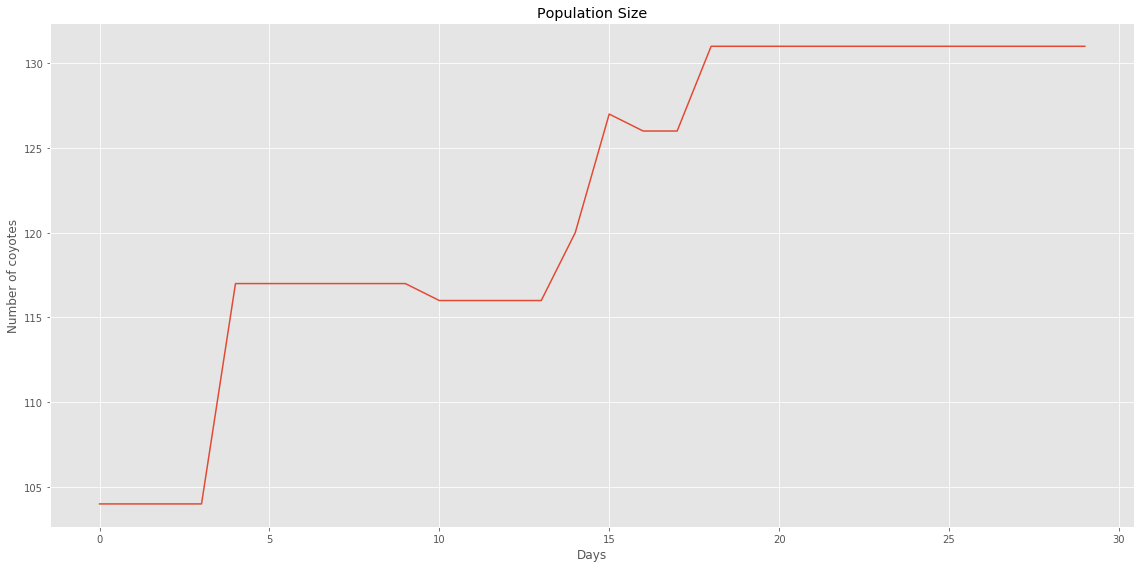

CPU times: user 6.58 s, sys: 648 ms, total: 7.22 s
Wall time: 6.46 s


In [16]:
%%time


for i in range(equalization):
    if (i +1) % 365 == 0: print(str(int((i+1)/365)) +"  years passed")
    a += [population.shape[0]]
    if population.shape[0] <=5 : break
    avg_age_list += [population['Age'].mean()]
    avg_boldness_list += [population['Boldness'].mean()]
    temporal_heterozigosity += [AllHeterozigosity(population)]
    temporal_FST += [FST()]
    if i % 30 == 0:
        plot_on_map2()
        plt.title("DAY " + str(i))
        plt.savefig('images_for_video/map'+str(i).zfill(5))
        plt.tight_layout()
        plt.close()
    Aday()
    
plt.plot(a)
plt.ylabel('Number of coyotes')
plt.xlabel('Days')
plt.title('Population Size')
plt.tight_layout()
plt.show()



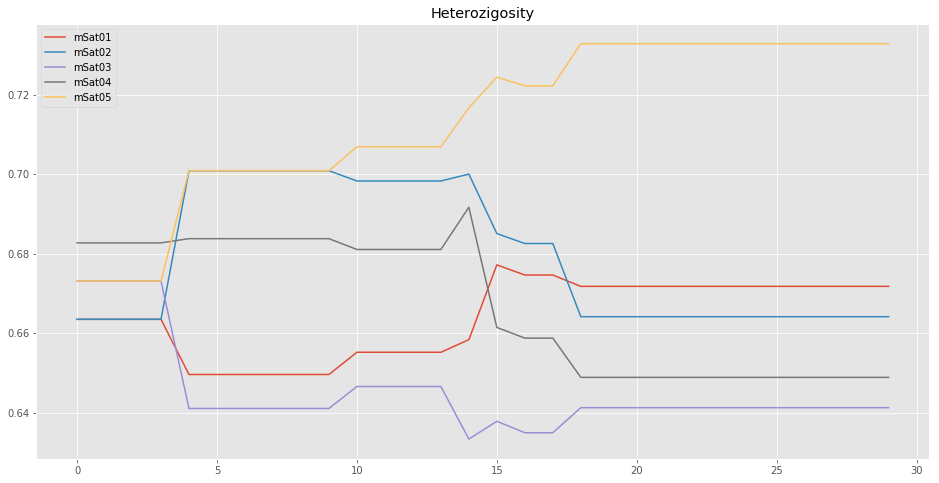

In [17]:
for i in range(NMICROSATS):
    plt.plot(np.array(temporal_heterozigosity)[:, i], label = 'mSat'+ str(i+1).zfill(2))
    
plt.title('Heterozigosity')
plt.legend(loc='best')
plt.savefig("heterozigosity var through time")
plt.show()

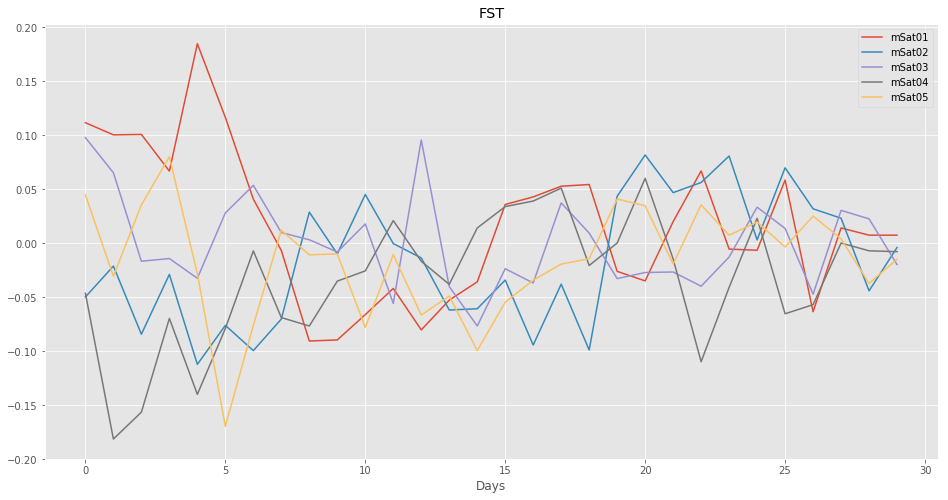

In [18]:
temporal_FST = np.array(temporal_FST)
for count, i in enumerate(['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]):
    plt.plot(temporal_FST[:, count], label = i)
    
plt.title("FST")
plt.xlabel('Days')
plt.legend(loc ="best")
plt.show()

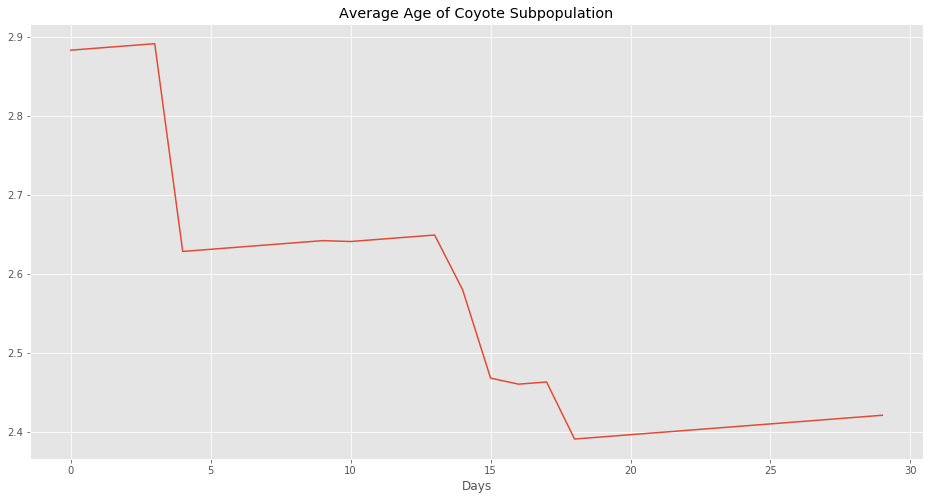

In [19]:
plt.plot(avg_age_list)
plt.title('Average Age of Coyote Subpopulation')
plt.xlabel('Days')
plt.savefig('Age var.png')
plt.show()

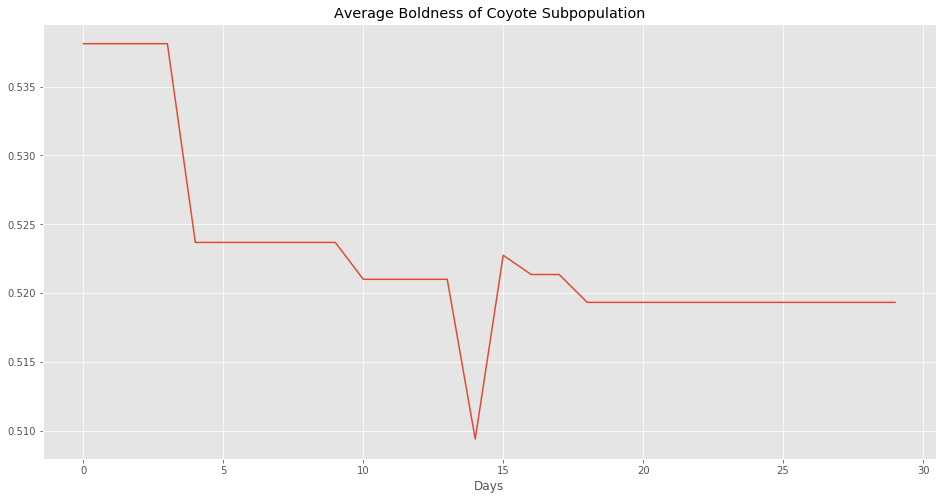

In [20]:
plt.plot(avg_boldness_list)
plt.title('Average Boldness of Coyote Subpopulation')
plt.xlabel('Days')
plt.show()

# Adding road to the simulation

In [21]:
topology = ski.img_as_float(rgb2gray(misc.imread("roads/simplest(1px10m)2.png")))

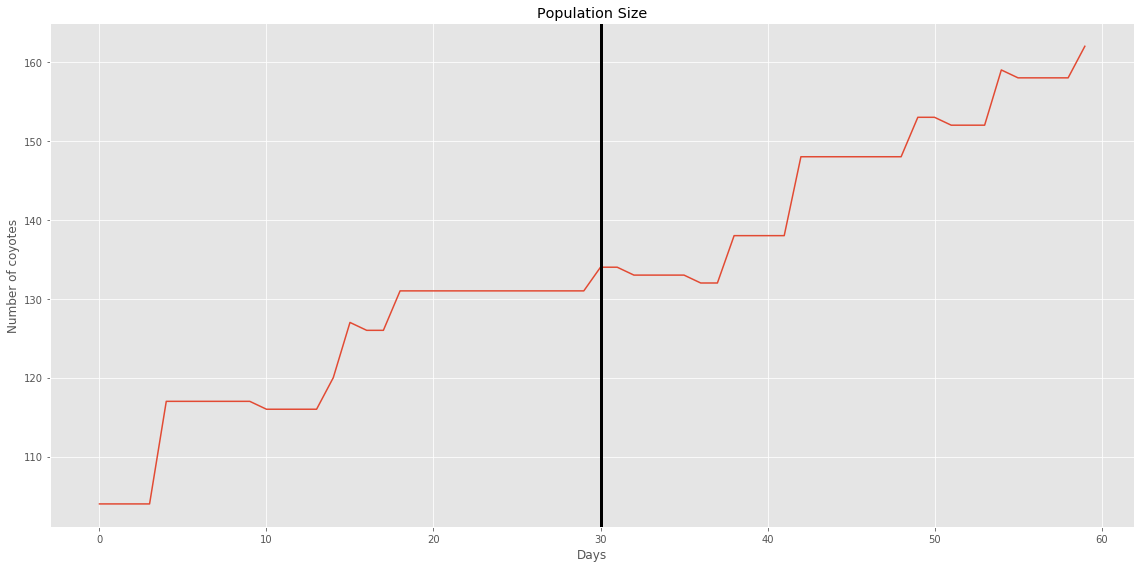

CPU times: user 7.74 s, sys: 732 ms, total: 8.47 s
Wall time: 7.64 s


In [22]:
%%time

temporal_FST = temporal_FST.tolist()
for i in range(30):
    if (i +1) % 365 == 0: print("1 of a year passed")
    a += [population.shape[0]]
    if population.shape[0] <=5 : break
    avg_age_list += [population['Age'].mean()]
    avg_boldness_list += [population['Boldness'].mean()]
    temporal_heterozigosity += [AllHeterozigosity(population)]
    temporal_FST += [FST()]
    if i % 30 == 0:
        plot_on_map2()
        plt.title("DAY " + str(i+ equalization))
        plt.savefig('images_for_video/map'+str(i+ equalization).zfill(5))
        plt.tight_layout()
        plt.close()
    Aday()
    
plt.plot(a)
plt.ylabel('Number of coyotes')
plt.xlabel('Days')
plt.axvline(equalization, color='black', linewidth = 3)
plt.title('Population Size')
plt.tight_layout()
plt.show()

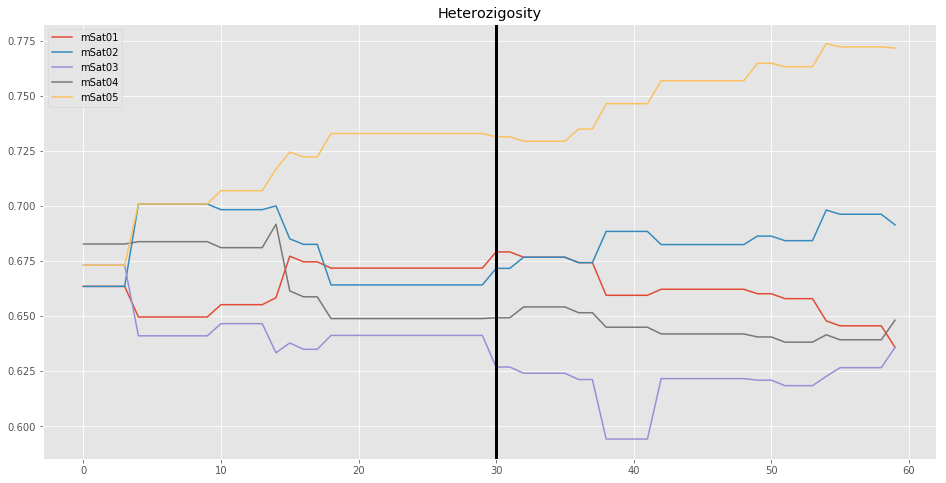

In [23]:
for i in range(NMICROSATS):
    plt.plot(np.array(temporal_heterozigosity)[:, i], label = 'mSat'+ str(i+1).zfill(2))
    
plt.title('Heterozigosity')
plt.legend(loc='best')
plt.axvline(equalization, color='black', linewidth = 3)
plt.savefig("heterozigosity var through time after road")
plt.show()

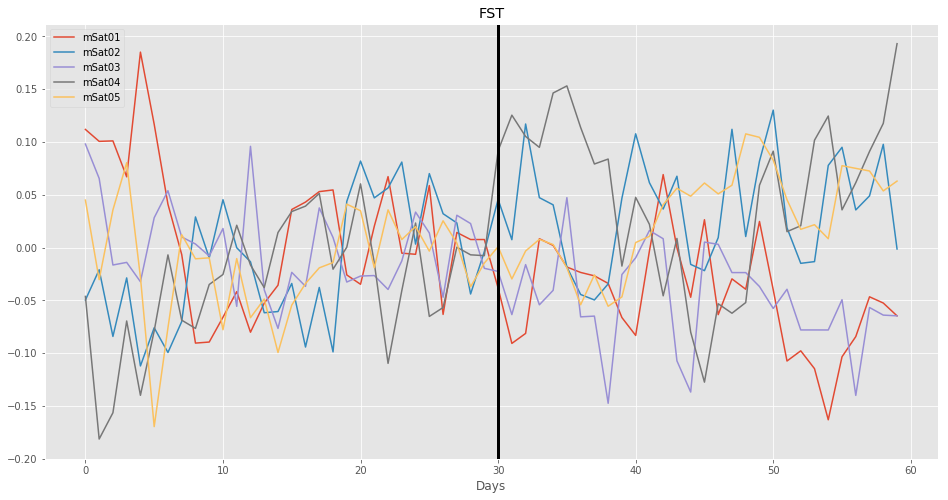

In [24]:
plt.rcParams["figure.figsize"] = (16,8)
temporal_FST = np.array(temporal_FST)
for count, i in enumerate(['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]):
    plt.plot(temporal_FST[:, count], label = i)
    
plt.title("FST")
plt.xlabel('Days')
plt.axvline(equalization, color='black', linewidth = 3)
plt.legend(loc ="best")
plt.savefig('FST variation')
plt.show()

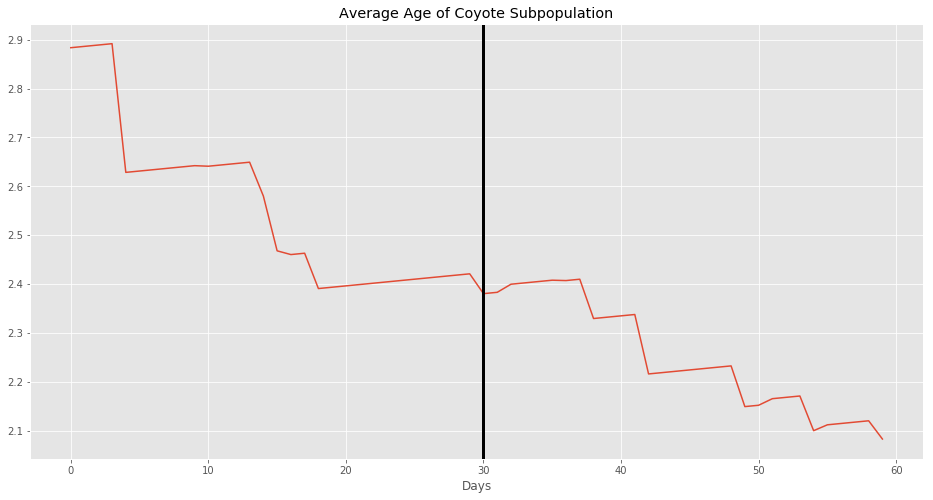

In [25]:
plt.plot(avg_age_list)
plt.title('Average Age of Coyote Subpopulation')
plt.xlabel('Days')
plt.axvline(equalization, color='black', linewidth = 3)
plt.savefig('Age var after road.png')
plt.show()

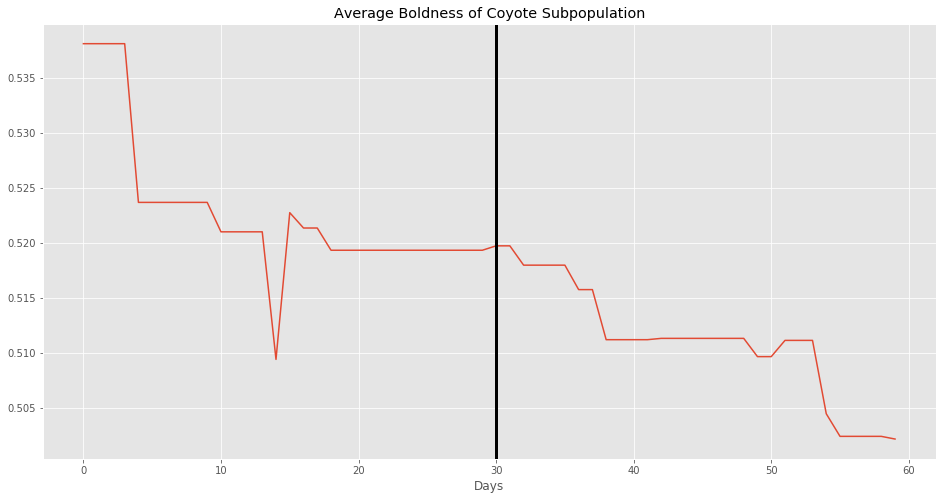

In [26]:
plt.plot(avg_boldness_list)
plt.title('Average Boldness of Coyote Subpopulation')
plt.axvline(equalization, color='black', linewidth = 3)
plt.xlabel('Days')
plt.savefig('variation in boldness')
plt.show()

# Example plots

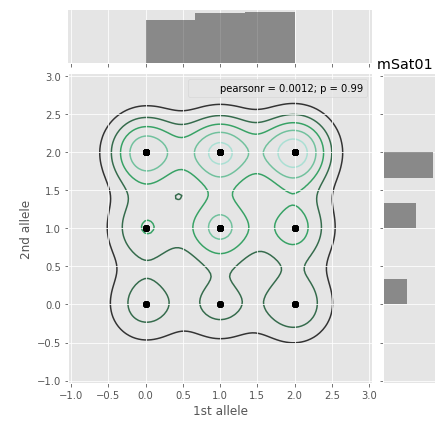

In [27]:
def plot_microsat_allele_dist(microsat, gray = 0):
    example = population.copy()
    example["1st allele"] = example[microsat].apply(lambda x : x[0] )
    example["2nd allele"] = example[microsat].apply(lambda x : x[1] )
    LE = LabelEncoder()
    LE.fit(example["1st allele"].values)

    LE2 = LabelEncoder()
    LE2.fit(example["2nd allele"].values)
    example["1st allele"] = example["1st allele"].apply(lambda x : LE.transform([x])[0])
    example["2nd allele"] = example['2nd allele'].apply(lambda x : LE2.transform([x])[0])
    if gray == 1: 
        (sns.jointplot("1st allele", "2nd allele", data=example, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=6))
        plt.title("                                                                                "+microsat)
        return 
    sns.jointplot("1st allele", "2nd allele", data=example, kind="kde", space=0, color="red")
    plt.title(microsat)


    
    
plot_microsat_allele_dist('mSat01',1)

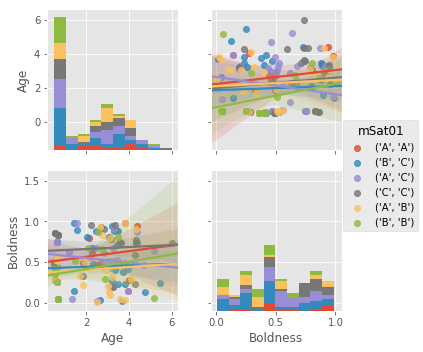

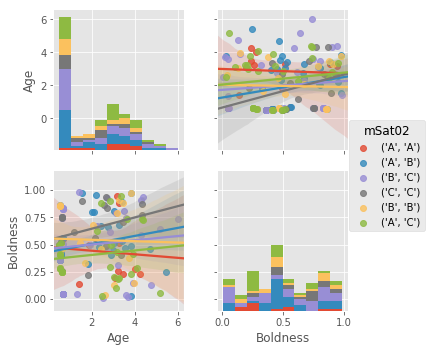

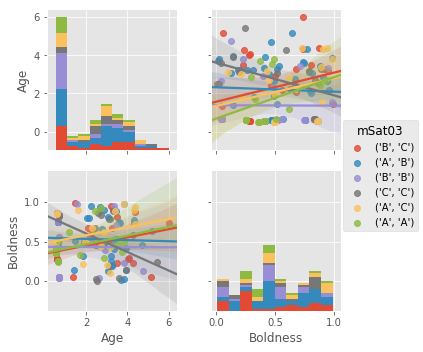

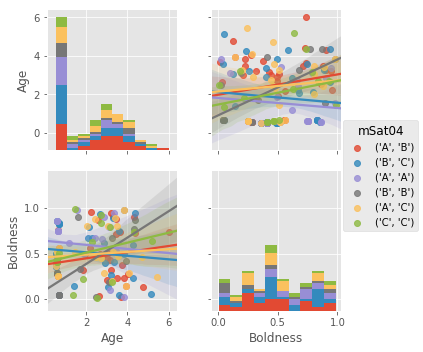

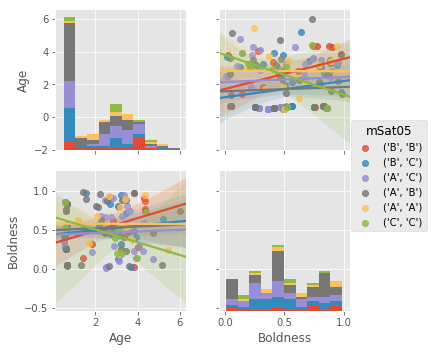

In [28]:
def fuse_equivalents(tup_alleles):
    return tuple(np.sort([tup_alleles[0], tup_alleles[1]]))

plt.rcParams["figure.figsize"] = (10,5)
example = population.copy()
#f, axarr = plt.subplots(ncols = 3, nrows =[int(NMICROSATS/3) if NMICROSATS%3 == 0 else int(NMICROSATS/3)+1][0])
for counter, i in enumerate(['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]):
    example[i] = example[i].apply(fuse_equivalents)
    sns.pairplot(example, hue=i,kind="reg")#, diag_kind="kde", plot_kws=dict(s=50, linewidth=1), diag_kws=dict(shade=True)) #  

#plt.show()
#plt.savefig("huehe")

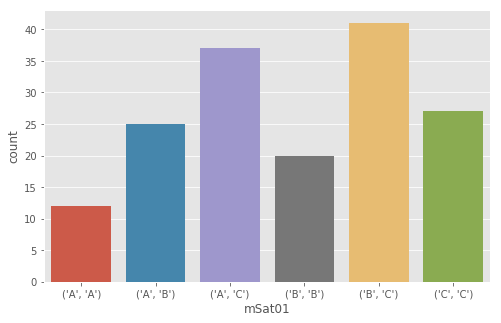

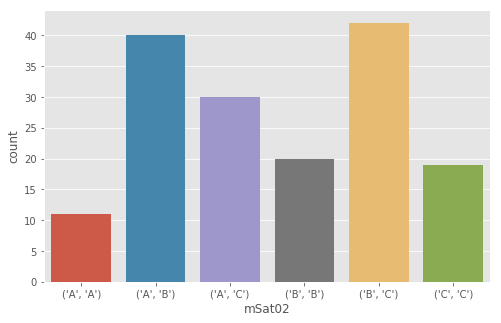

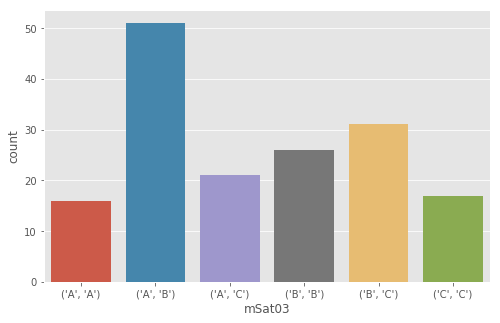

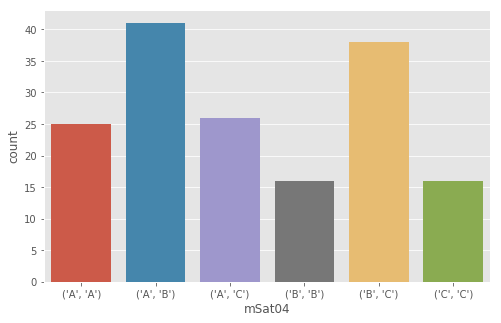

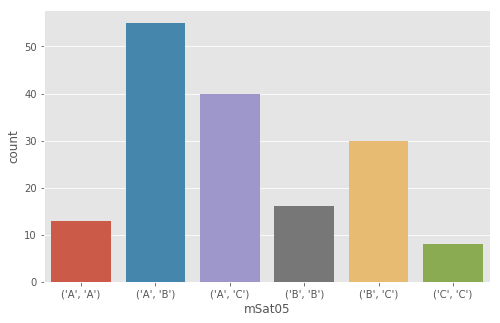

In [29]:
def fuse_equivalents(tup_alleles):
    return tuple(np.sort([tup_alleles[0], tup_alleles[1]]))

plt.rcParams["figure.figsize"] = (8,5)
example = population.copy()
for i in ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]:
    example[i] = example[i].apply(fuse_equivalents)
    example = example.sort_values(by=i)
    sns.countplot(x=i, data=example)
    plt.show()
    


In [30]:
system("convert images_for_video/map*.png  images_for_video/animation.mp4 ")

0

In [31]:
population['Age'].mean()

2.0854970032686242

In [32]:


#fig, ax = plt.subplots(ncols = 3, nrows =[int(NMICROSATS/3) if NMICROSATS%3 == 0 else int(NMICROSATS/3)+1][0])
#population['mSat01'].value_counts().plot(ax=ax, kind='bar')

#example = population.copy()
#for count, i in enumerate(['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]):
#    example[i] = example[i].apply(fuse_equivalents)
#    ax[count%3, count/3].plot( population['mSat01'].value_counts(),kind='bar')
#    ax[count%3, count/3].set_title(i)
#    plt.show()

In [64]:


unique_elements, counts_elements = np.unique(list(population['mSat01'].values), return_counts=True)
counts_elements = np.array(counts_elements/sum(counts_elements))
Heter =1 - sum(counts_elements*counts_elements)

1.0


In [68]:
def Expected_Heterozigosity(loci, pop):
    unique_elements, counts_elements = np.unique(list(pop[loci].values), return_counts=True)
    counts_elements = np.array(counts_elements/sum(counts_elements))
    return 1 - sum(counts_elements*counts_elements)

def Expected_AllHeterozigosity(pop):
    return [Expected_Heterozigosity(i, pop) for i in ['mSat'+ str(i+1).zfill(2) for i in range(NMICROSATS)]]

def Expected_FST():
    example = population.copy()
    example['side'] = example.Position.apply(lambda x: ["A" if x[1]>500 else "B"][0])
    example.head()
    sidea = example[example.side == 'A']
    sideb = example[example.side == 'B']
    if sidea.shape[0] == 0 or sideb.shape[0]==0: return np.array([0 for i in range(NMICROSATS)])
    HA = np.array(Expected_AllHeterozigosity(sidea))
    HB = np.array(Expected_AllHeterozigosity(sidea))
    Hpop = np.array(Expected_AllHeterozigosity(population))         
    return (Hpop - (HA+HB)/2)/ Hpop

In [69]:
print(unique_elements, counts_elements)
print(Heter)

['A' 'B' 'C'] [ 0.2654321   0.32716049  0.40740741]
0.656531016613


In [74]:
%%time
print(Expected_FST(),FST())

[ 0.00948149 -0.00589089 -0.01018935  0.01850396 -0.00652594] [ 0.01137309  0.00816327 -0.03356449  0.16244898 -0.01828571]
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 14 ms
